In [4]:
!pip install torchsummary
!pip install torchvision 
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
#from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):

        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), 
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), 
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Flatten(), 
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):

        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), 
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=0),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh() 
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
#MODEL REUSING https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

In [35]:
def train(epoch, train_loader, optimizer, encoder, decoder):
    log_interval=50
    train_losses = []
    train_counter = []
    loss_f= torch.nn.MSELoss()
    encoder.train()
    decoder.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        encoded_data = encoder(data)
        # Decode data
        decoded_data = decoder(encoded_data)
        loss = loss_f(decoded_data, data)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*1000) + ((epoch-1)*len(train_loader.dataset)))
def test(test_loader, encoder, decoder):
    loss_f= torch.nn.MSELoss()
    test_losses = []
    encoder.eval()
    decoder.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            encoded_data = encoder(data)
            # Decode data
            global output
            output= decoder(encoded_data)
            test_loss += loss_f(output,data).item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f} \n'.format(
        test_loss))
    #output image plotting
    fig, ax = plt.subplots(figsize=(30,30))
    print(output.shape)
    img=torchvision.utils.make_grid(output[:10],10,1)
    print(output[:100].shape, img.shape)
    npimg = img.numpy()
    # fig.add_subplot(2, 2, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # img=torchvision.utils.make_grid(output[:10],10,3)
    # print(output[:100].shape, img.shape)
    # npimg = img.numpy()
    # fig.add_subplot(2, 2, 2)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # img=torchvision.utils.make_grid(output[:100],7,4)
    # print(output[:100].shape, img.shape)
    # npimg = img.numpy()
    # fig.add_subplot(2, 2, 3)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # img=torchvision.utils.make_grid(output[:100],5,6)
    # print(output[:100].shape, img.shape)
    # npimg = img.numpy()
    # fig.add_subplot(2, 2, 3)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()

def short_cut(n_epochs, batch_size_train,batch_size_test):
    mean = (0.1307, )
    std = (0.3081, ) 
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../', train=True, download=False,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    (0,), (255,)))
                                ])),batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../', train=False, download=False,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    (0,), (255,))
                                ])),batch_size=batch_size_test, shuffle=True)

    encoder=Encoder(num_input_channels=1, base_channel_size=32, latent_dim=256)
    decoder=Decoder(num_input_channels=1, base_channel_size=32, latent_dim=256)

    learning_rate = 0.01

    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optimizer = torch.optim.Adam(params_to_optimize,lr=learning_rate)

    for epoch in range(1, n_epochs + 1):
        train(epoch=epoch, train_loader=train_loader, optimizer=optimizer, encoder=encoder,decoder=decoder)
    test(test_loader=test_loader, encoder=encoder,decoder=decoder)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 70 (1953355919.py, line 73)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 1, 28, 28])
torch.Size([1, 1, 28, 28]) torch.Size([3, 28, 280])


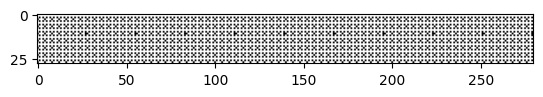

In [37]:
print(output.shape)
img=torchvision.utils.make_grid(output[:10], 10, 0)
print(output[:1].shape, img.shape)
npimg = img.numpy()
# fig.add_subplot(2, 2, 1)
plt.imshow(np.transpose(npimg, (1, 2, 0)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.060057
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.000134
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.018487
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.013329
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.984950
Train Epoch: 1 [25000/60000 (42%)]	Loss: 2.004489
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.015580
Train Epoch: 1 [35000/60000 (58%)]	Loss: 2.001185
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.989340
Train Epoch: 1 [45000/60000 (75%)]	Loss: 1.975688
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.990889
Train Epoch: 1 [55000/60000 (92%)]	Loss: 2.009851
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.010704
Train Epoch: 2 [5000/60000 (8%)]	Loss: 1.992567
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.980780
Train Epoch: 2 [15000/60000 (25%)]	Loss: 2.025352
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.959410
Train Epoch: 2 [25000/60000 (42%)]	Loss: 2.018482
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.023818
Train Epoch: 2 [35000/60000 (58%)]	Loss: 1.989745
Train Epoch: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Avg. loss: 0.0201 

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28]) torch.Size([3, 30, 291])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28]) torch.Size([3, 62, 242])


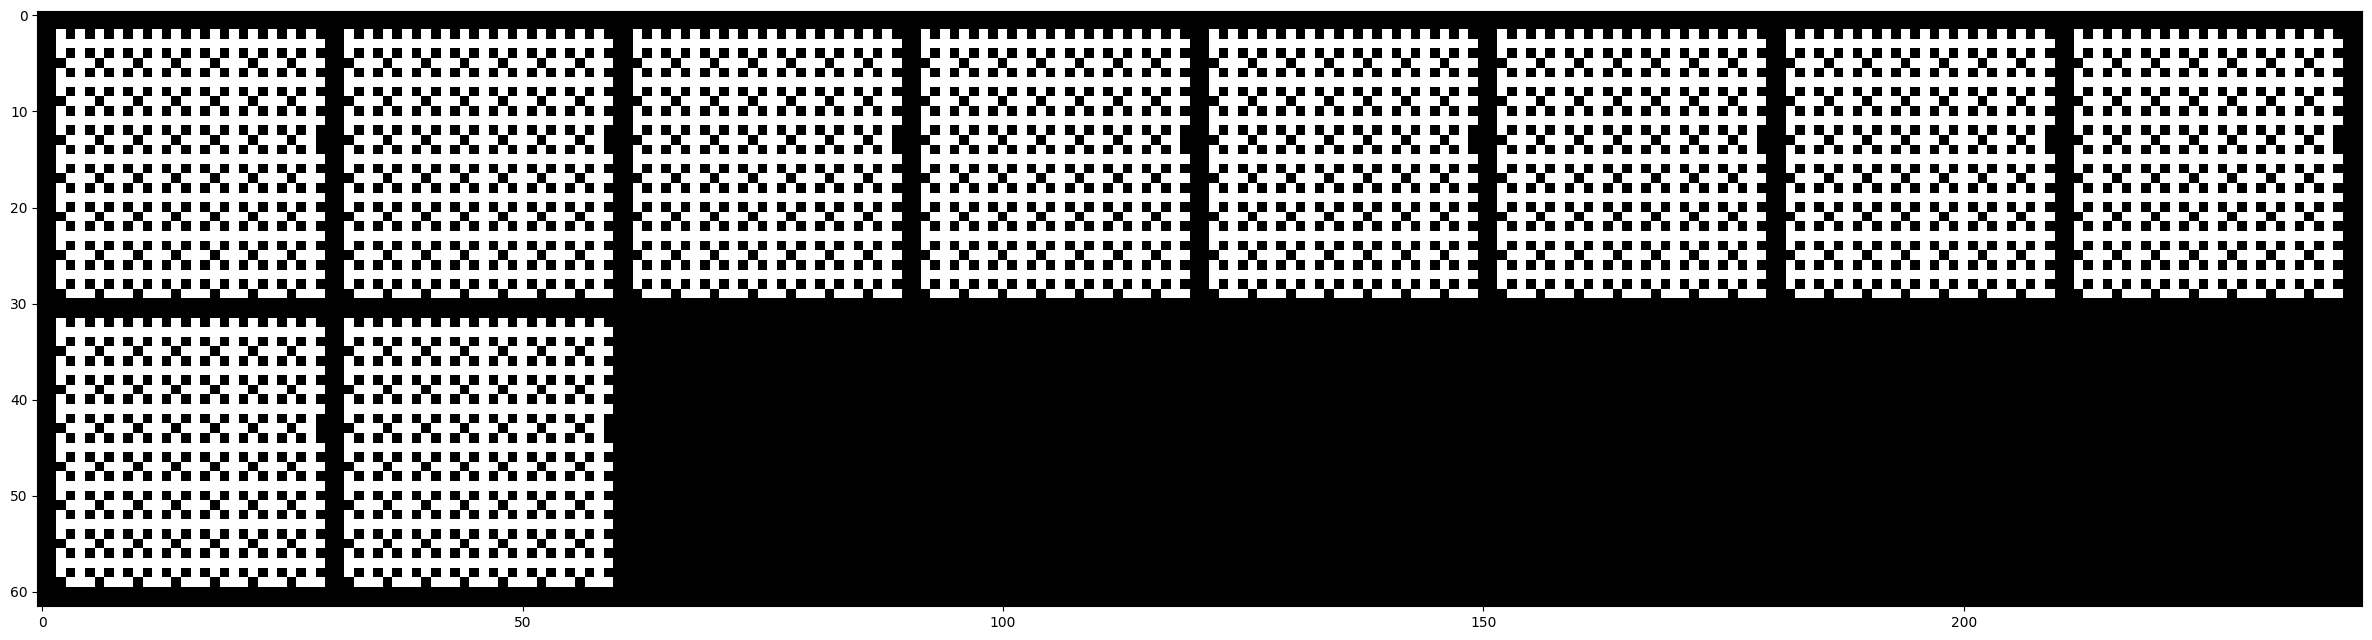

In [36]:
short_cut(8,100,100)

print(output.shape)
img=torchvision.utils.make_grid(output[:10])
print(output[:100].shape, img.shape)
npimg = img.numpy()
# fig.add_subplot(2, 2, 1)
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [13]:
batch_size_train=5
batch_size_test =5

train_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./', train=True, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./', train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),batch_size=batch_size_test, shuffle=True)
#for batch_idx, (data, target) in enumerate(train_loader):
    ##print(batch_idx)
    #fig, ax = plt.subplots(figsize=(20, 8.5))
    #img=torchvision.utils.make_grid(data[:5],10,5)
    #npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()



##for label, img  in enumerate(examples):
 #  print(img[]shape)
 #  plt.imshow(img.squeeze().permute((1,2)), cmap="gray")
   
  # plt.show()
 #  print(f"Label: {label}")

#https://www.kaggle.com/code/teyang/neural-network-mnist-using-pytorch/notebook
for img, _  in train_loader:
    print('img.shape:', img.shape)
    #plt.figure(figsize=(16,8))
    #plt.axis('off')
    grid_img=make_grid(img)
    print('img.shape:', grid_img.shape)
    plt.imshow(grid_img.permute(1, 2, 0))
    break
    #plt.show(img)
#  break

RuntimeError: Dataset not found. You can use download=True to download it

In [83]:
img.shape

torch.Size([5])

In [36]:
examples = next(iter(train_loader))
examples[0].squeeze().shape

torch.Size([5, 28, 28])

In [39]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


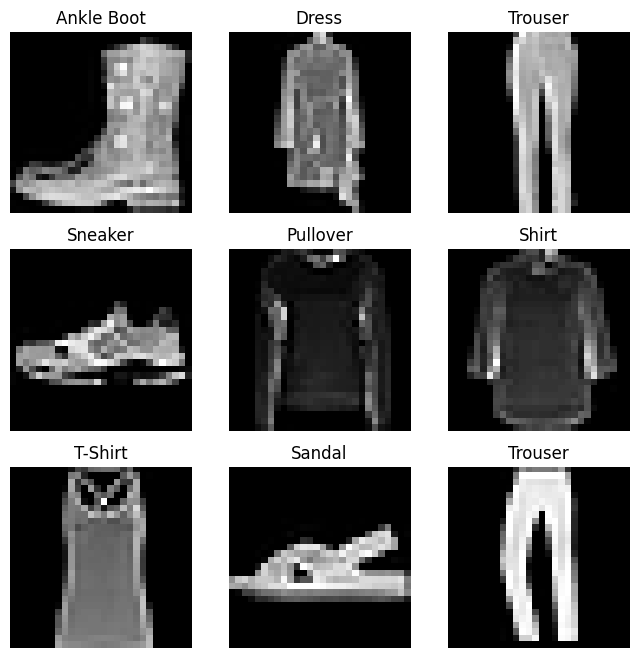

In [41]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    print(img.squeeze().shape)
plt.show()